# Using Convolutional Neural Networks (CNN) to Estimate Skribll Drawings

Using wget commands to retrive data from a storage from cloud


In [1]:
!mkdir data
%cd data

mkdir: cannot create directory 'data': File exists
/kaggle/working/data


In [2]:
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/calculator.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/camera.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/computer.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/envelope.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/headphones.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/mouse.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/radio.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/spreadsheet.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/telephone.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/television.npy

--2024-02-14 14:16:34--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.207, 173.194.79.207, 108.177.96.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93581456 (89M) [application/octet-stream]
Saving to: 'book.npy.1'

book.npy.1          100%[===================>]  89.25M  27.0MB/s    in 3.3s    

2024-02-14 14:16:38 (27.0 MB/s) - 'book.npy.1' saved [93581456/93581456]

--2024-02-14 14:16:39--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/calculator.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.207, 108.177.127.207, 142.251.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100646080 (96M) [application/octet-stre

In [3]:
!ls

book.npy	  computer.npy	    laptop.npy	  spreadsheet.npy
book.npy.1	  computer.npy.1    laptop.npy.1  spreadsheet.npy.1
calculator.npy	  envelope.npy	    mouse.npy	  telephone.npy
calculator.npy.1  envelope.npy.1    mouse.npy.1   telephone.npy.1
camera.npy	  headphones.npy    radio.npy	  television.npy
camera.npy.1	  headphones.npy.1  radio.npy.1   television.npy.1


In [4]:
%cd

/root


In [5]:
from sklearn.model_selection import train_test_split as train_test_split
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
#from keras.utils import np_utils
from random import randint
import numpy as np
import os
from PIL import Image
from tensorflow.keras.utils import to_categorical # this is changed to to_categorical

2024-02-14 14:17:33.542563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 14:17:33.542698: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 14:17:33.683178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Creating Output Categories

In [6]:
# Creates a dictionary with all the categories.
CATEGORIES = { 
    0: "Book",
    1: "Calculator",
    2: "Camera",
    3: "Computer",
    4: "Envelope",
    5: "Headphones",
    6: "Laptop",
    7: "Mouse",
    8: "Radio",
    9: "Spreadsheet",
    10: "Telephone",
    11: "Television",
}
N_CATEGORIES = len(CATEGORIES)

# Defines the number of drawings per category to take in.
N = 7500

# Defines the number of epochs (iterations of training) the model will undergo.
N_EPOCHS = 10

# The files to learn from. They MUST match the information in CATEGORIES for proper classification.
files = ["book.npy", "calculator.npy", "camera.npy", "computer.npy", "envelope.npy", "headphones.npy", "laptop.npy", "mouse.npy", "radio.npy", "spreadsheet.npy", "telephone.npy", "television.npy"]

### Defining Functions for Loading Directories and Data Preprocessing

In [7]:
def load(dir,reshaped, files):
  # Takes the .npy files and return them as arrays.
    data = [ ]
    for file in files:
        f = np.load(dir + file)
        if reshaped:
            new_f =[]
            for i in range(len(f)):
                x = np.reshape(f[i], (28,28))
                x = np.expand_dims(x, axis = 0)
                x = np.reshape(f[i], (28,28,1))
                new_f.append(x)
            f = new_f
        data.append(f)
    return data

def normalize(data):
  # Takes a list ot a list of lists and returns its normalized form.
  return np.interp(data, [0,255],[-1,1])

def denormalize(data):
  # Takes a list ot a list of lists and returns its denormalized form.
  return np.interp(data,[-1,1],[0,255])

def visualize(array):
  # Visualizes a 2D array as an Image.
    array = np.reshape(array, (28,28))
    img = Image.fromarray(array)
    return img 

def set_limit(arrays, n):
  # Limits the elements from each array up to the nth element and returns a single list.
    new = []
    for array in arrays:
        i = 0
        for item in array:
            if i == n:
                break
            new.append(item)
            i += 1
    return new

def make_labels(N1, N2):
  # Make labels from 0 to N1, each repeated N2 times.
    labels = []
    for i in range(N1):
        labels += [i] *N2
    return labels

### Defining Functions for Plotting

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotFromHistory(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [9]:
import matplotlib.pyplot as plt

def plotFromHistories(histories, title, hyperparam_name, hyperparam_values):
    plt.figure(figsize=(16, 8))

    # Plotting accuracy
    plt.subplot(2, 2, 1)
    for i, history in enumerate(histories):
        acc = history.history['accuracy']
        plt.plot(range(1, len(acc) + 1), acc, 'o-', label=f'Training Accuracy ({hyperparam_name} = {hyperparam_values[i]})')

    plt.title(f'Training Accuracy - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(1, len(acc) + 1))

    # Plotting validation accuracy
    plt.subplot(2, 2, 2)
    for i, history in enumerate(histories):
        val_acc = history.history['val_accuracy']
        plt.plot(range(1, len(val_acc) + 1), val_acc, 'o-', label=f'Validation Accuracy ({hyperparam_name} = {hyperparam_values[i]})')

    plt.title(f'Validation Accuracy - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(1, len(val_acc) + 1))

    # Plotting loss
    plt.subplot(2, 2, 3)
    for i, history in enumerate(histories):
        loss = history.history['loss']
        plt.plot(range(1, len(loss) + 1), loss, 'o-', label=f'Training Loss ({hyperparam_name} = {hyperparam_values[i]})')

    plt.title(f'Training Loss - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(range(1, len(loss) + 1))

    # Plotting validation loss
    plt.subplot(2, 2, 4)
    for i, history in enumerate(histories):
        val_loss = history.history['val_loss']
        plt.plot(range(1, len(val_loss) + 1), val_loss, 'o-', label=f'Validation Loss ({hyperparam_name} = {hyperparam_values[i]})')

    plt.title(f'Validation Loss - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(range(1, len(val_loss) + 1))

    # Show the plots
    plt.tight_layout()
    plt.show()

### Visualising Images in 28*28 Pixels Format

In [10]:
images = load("/kaggle/working/data/", False, ["book.npy"])
visualize(images[0][0])

### Train Test Split & One Hot Encoding on Target Class

In [11]:
# Loads the content into /content/data/ while reshaping images to 28 x 28 (second True argument). A ConvNet expects this format.

# the directory can be changed to content/data
images = load("/kaggle/working/data/", True, files)

images = set_limit(images, N)
# Normalizes the values and makes the values -1 to 1. This ensures better performance of the model.
images = list(map(normalize, images))

labels = make_labels(N_CATEGORIES, N)

# Reserves 5 percent of the dataset for training purposes only (test_size) and splits the data into training and testing datasets.
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.05)

# Performs one-hot encoding.
Y_train = to_categorical(y_train, N_CATEGORIES)
Y_test = to_categorical(y_test, N_CATEGORIES)

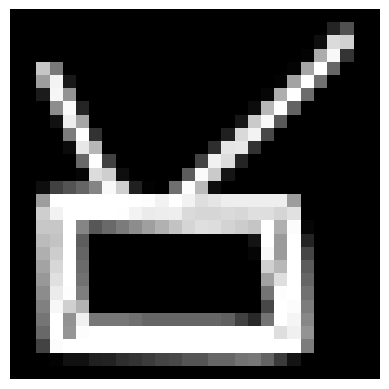

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the first image
plt.imshow(x_train[0], cmap='gray')
plt.axis('off')  # Hide axis
plt.show()

We find out that 28x28 px is blurry and less representative of the data, hence we increase the px to 64x64

### Resize Images to 64*64 Pixels

In [13]:
def load(dir,reshaped, files):
  # Takes the .npy files and return them as arrays.
    data = [ ]
    for file in files:
        f = np.load(dir + file)
        if reshaped:
            new_f =[]
            for i in range(len(f)):
                x = np.reshape(f[i], (64,64))
                x = np.expand_dims(x, axis = 0)
                x = np.reshape(f[i], (64,64,1))
                new_f.append(x)
            f = new_f
        data.append(f)
    return data

def normalize(data):
  # Takes a list ot a list of lists and returns its normalized form.
  return np.interp(data, [0,255],[-1,1])

def denormalize(data):
  # Takes a list ot a list of lists and returns its denormalized form.
  return np.interp(data,[-1,1],[0,255])

def visualize(array):
  # Visualizes a 2D array as an Image.
    array = np.reshape(array, (64,64))
    img = Image.fromarray(array)
    return img 

def set_limit(arrays, n):
  # Limits the elements from each array up to the nth element and returns a single list.
    new = []
    for array in arrays:
        i = 0
        for item in array:
            if i == n:
                break
            new.append(item)
            i += 1
    return new

def make_labels(N1, N2):
  # Make labels from 0 to N1, each repeated N2 times.
    labels = []
    for i in range(N1):
        labels += [i] *N2
    return labels

In [14]:
import cv2

# Resize images to the desired shape (64x64 pixels)
resized_x_train = [cv2.resize(image, (64, 64)) for image in x_train]
resized_x_test = [cv2.resize(image, (64, 64)) for image in x_test]

# Reshape images to add the channel dimension (1 for grayscale)
resized_x_train = np.array(resized_x_train).reshape(-1, 64, 64, 1)
resized_x_test = np.array(resized_x_test).reshape(-1, 64, 64, 1)

# Now you can use resized_x_train and resized_x_test as input to your model

In [15]:
print("The shape of resized X train is", resized_x_train.shape)
print("The shape of resized X test is", resized_x_test.shape)

The shape of resized X train is (85500, 64, 64, 1)
The shape of resized X test is (4500, 64, 64, 1)


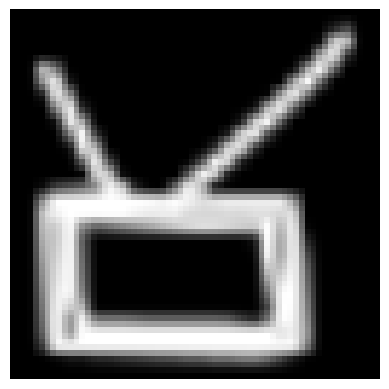

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Reshape the array
image_array = resized_x_train.reshape((85500, 64, 64))

# Plot the first image
plt.imshow(image_array[0], cmap='gray')
plt.axis('off')  # Hide axis
plt.show()

### Using Unsharp Masking (USM) to sharpen images

Since the images of resized (64*64 px) are blurry, hence we can apply sharpening of images, using USM

In [17]:
import cv2
import numpy as np

def unsharp_masking(image, sigma=1.0, strength=1.5):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    # Add channel dimension to match the shape of input images
    sharpened = np.expand_dims(sharpened, axis=-1)
    return sharpened

# Create arrays to store sharpened images
sharpened_x_train = np.zeros_like(resized_x_train)
sharpened_x_test = np.zeros_like(resized_x_test)

# Apply unsharp masking to resized_x_train
for i, image in enumerate(resized_x_train):
    sharpened_x_train[i] = unsharp_masking(image)

# Apply unsharp masking to resized_x_test
for i, image in enumerate(resized_x_test):
    sharpened_x_test[i] = unsharp_masking(image)


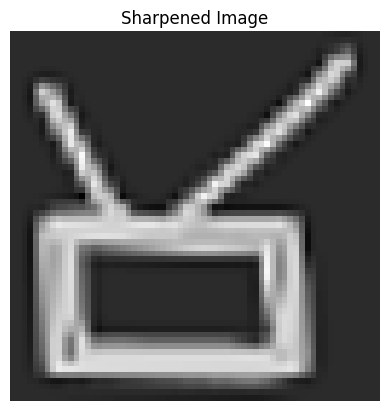

In [18]:
import matplotlib.pyplot as plt

# Example showing the first sharpened image in sharpened_x_train
plt.imshow(sharpened_x_train[0].squeeze(), cmap='gray')  # Assuming grayscale images
plt.axis('off')  # Turn off axis
plt.title('Sharpened Image')
plt.show()


Equation for Sharpening Images

$$Sharpened Image=Original Image+Strength×(Original Image−Blurred Image)$$

Hyperparameters into play:
- sigma: a parameter used in Gaussian blur, that is a crucial step in the unsharp masking technique. Gaussian blue is applied to the original image to create a blurred version, then the sigma value can determine the size of the Gaussian kernel, affecting the amount of blurring applied to the image. Higher sigma values result in more extensive blurring, and vice versa.

- strength: a parameter controlling the intensity of the sharpening effect in unsharp masking. After applying Gaussian blur to original image, this blurred image is subtracted from the original image, obtaining the mask that highlights the edges and details. Then, the strength parameters takes a proportion of the mask added back to the original image, hence enhancing its sharpness. Higher strength values increase the contrast between edges and produced a stronger sharpening effect, and vice versa.

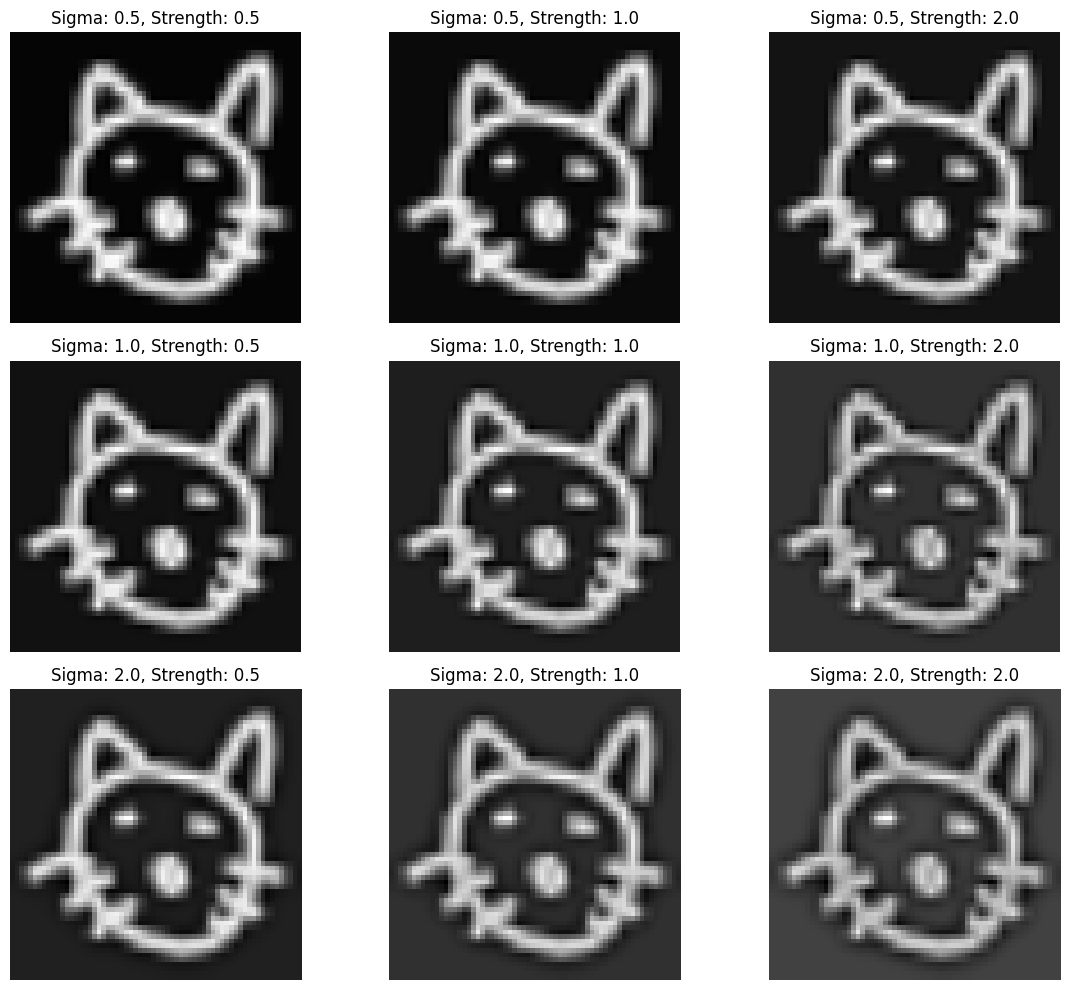

In [19]:
import matplotlib.pyplot as plt

def unsharp_masking(image, sigma=1.0, strength=1.5):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    # Add channel dimension to match the shape of input images
    sharpened = np.expand_dims(sharpened, axis=-1)
    return sharpened

# Define parameter combinations to tune
sigmas = [0.5, 1.0, 2.0]  # Sigma values for Gaussian blur
strengths = [0.5, 1.0, 2.0]  # Strength values for sharpening

# Visualize sharpened images for different parameter combinations
fig, axes = plt.subplots(len(sigmas), len(strengths), figsize=(12, 10))

for i, sigma in enumerate(sigmas):
    for j, strength in enumerate(strengths):
        # Apply unsharp masking with current parameter combination
        sharpened_image = unsharp_masking(image, sigma=sigma, strength=strength)
        
        # Visualize the sharpened image
        axes[i, j].imshow(sharpened_image.squeeze(), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f"Sigma: {sigma}, Strength: {strength}")

plt.tight_layout()
plt.show()


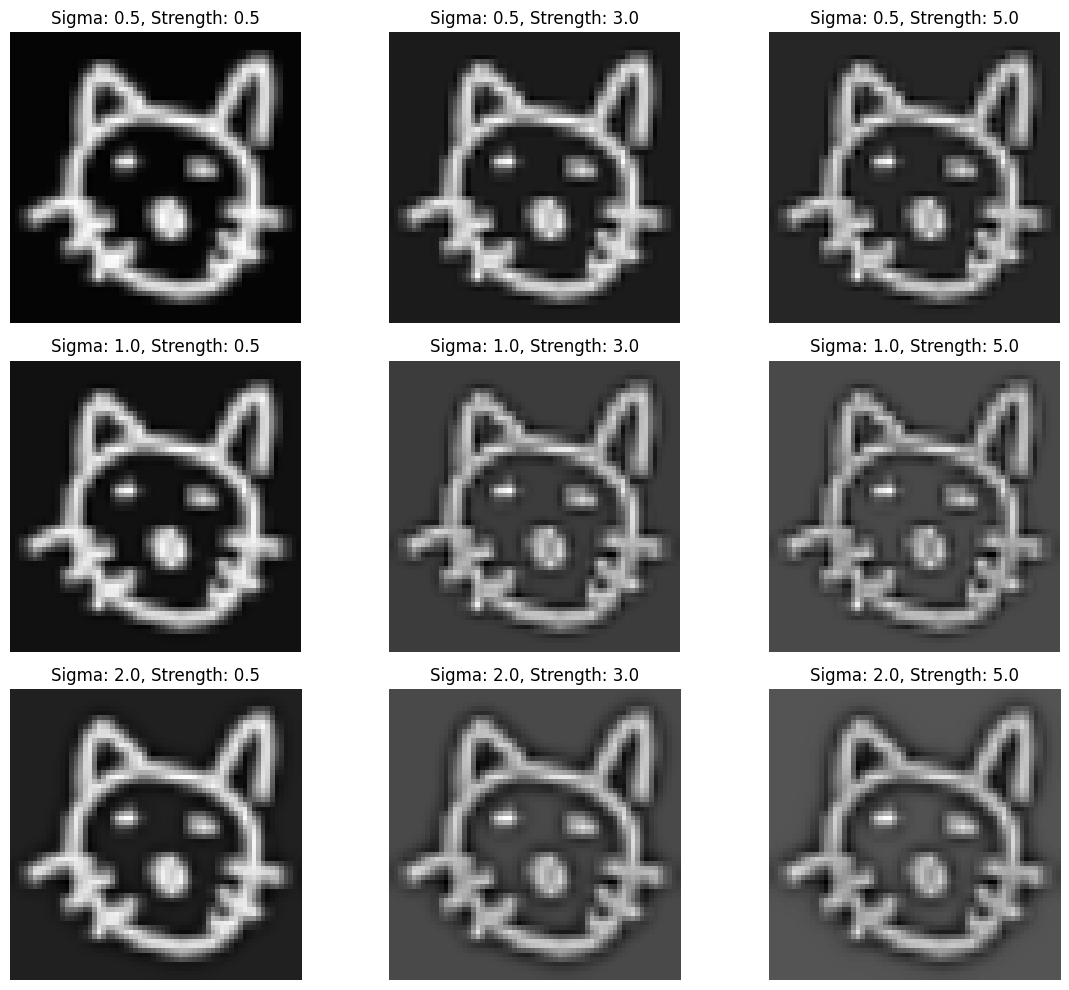

In [20]:
import matplotlib.pyplot as plt

def unsharp_masking(image, sigma=1.0, strength=1.5):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    # Add channel dimension to match the shape of input images
    sharpened = np.expand_dims(sharpened, axis=-1)
    return sharpened

# Define parameter combinations to tune
sigmas = [0.5, 1.0, 2.0]  # Sigma values for Gaussian blur
strengths = [0.5, 3.0, 5.0]  # Strength values for sharpening

# Visualize sharpened images for different parameter combinations
fig, axes = plt.subplots(len(sigmas), len(strengths), figsize=(12, 10))

for i, sigma in enumerate(sigmas):
    for j, strength in enumerate(strengths):
        # Apply unsharp masking with current parameter combination
        sharpened_image = unsharp_masking(image, sigma=sigma, strength=strength)
        
        # Visualize the sharpened image
        axes[i, j].imshow(sharpened_image.squeeze(), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f"Sigma: {sigma}, Strength: {strength}")

plt.tight_layout()
plt.show()


From the provided images showing various levels of sharpening strength, it appears that as the strength increases, the images become more contrasted and the edges more pronounced. However, increasing the strength too much can lead to oversharpening, where artifacts become noticeable and can degrade the image quality. Oversharpening can introduce noise and may cause a model to learn incorrect features.

In [21]:
def generate_datasets(images, sigma, strength):
    dataset = [unsharp_masking(image, sigma=sigma, strength=strength) for image in images]
    return [(dataset, sigma, strength)]


In [25]:
[(x_trainUSM1, sigma, strength)] = generate_datasets(resized_x_train, 0.5, 0.5)

In [25]:
[(x_trainUSM2, sigma, strength)] = generate_datasets(resized_x_train, 0.5, 1)

In [26]:
[(x_trainUSM3, sigma, strength)] = generate_datasets(resized_x_train, 0.5, 2)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, (3,3), activation="relu"),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(12, activation="softmax")
    ])
    model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
    model.summary()
    return model

In [39]:
modelUSM0 = create_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 12544)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [37]:
modelUSM1 = create_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [30]:
modelUSM2 = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [31]:
modelUSM3 = create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [40]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
historyUSM0 = modelUSM0.fit(
    np.array(resized_x_train),
    np.array(Y_train),
    batch_size=32,
    epochs=10,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 12s 5ms/step - loss: 0.6360 - accuracy: 0.8038 - val_loss: 0.5452 - val_accuracy: 0.8363
Epoch 2/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.4517 - accuracy: 0.8594 - val_loss: 0.5209 - val_accuracy: 0.8388
Epoch 3/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3833 - accuracy: 0.8792 - val_loss: 0.5183 - val_accuracy: 0.8442
Epoch 4/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3368 - accuracy: 0.8910 - val_loss: 0.5638 - val_accuracy: 0.8442
Epoch 5/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2914 - accuracy: 0.9051 - val_loss: 0.5967 - val_accuracy: 0.8324
Epoch 6/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2596 - accuracy: 0.9148 - val_loss: 0.6764 - val_accuracy: 0.8305
Epoch 7/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2286 - accuracy: 0.9243 - val_loss: 0.7574 - val_ac

In [38]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
history = modelUSM1.fit(
    np.array(x_trainUSM1),
    np.array(Y_train),
    batch_size=32,
    epochs=10,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 12s 5ms/step - loss: 0.6281 - accuracy: 0.8044 - val_loss: 0.5390 - val_accuracy: 0.8274
Epoch 2/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.4427 - accuracy: 0.8596 - val_loss: 0.4908 - val_accuracy: 0.8485
Epoch 3/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3702 - accuracy: 0.8817 - val_loss: 0.5000 - val_accuracy: 0.8506
Epoch 4/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3052 - accuracy: 0.8996 - val_loss: 0.5652 - val_accuracy: 0.8399
Epoch 5/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2584 - accuracy: 0.9147 - val_loss: 0.5840 - val_accuracy: 0.8302
Epoch 6/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2161 - accuracy: 0.9268 - val_loss: 0.7531 - val_accuracy: 0.8351
Epoch 7/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2004 - accuracy: 0.9328 - val_loss: 0.8391 - val_ac

In [32]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
historyUSM2 = modelUSM2.fit(
    np.array(x_trainUSM2),
    np.array(Y_train),
    batch_size=32,
    epochs=10,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10


I0000 00:00:1707909834.975106     787 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2138/2138 [==============================] - 15s 5ms/step - loss: 0.6521 - accuracy: 0.7976 - val_loss: 0.5313 - val_accuracy: 0.8326
Epoch 2/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.4474 - accuracy: 0.8599 - val_loss: 0.5031 - val_accuracy: 0.8458
Epoch 3/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3806 - accuracy: 0.8786 - val_loss: 0.5461 - val_accuracy: 0.8425
Epoch 4/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3203 - accuracy: 0.8945 - val_loss: 0.5527 - val_accuracy: 0.8449
Epoch 5/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2839 - accuracy: 0.9067 - val_loss: 0.6372 - val_accuracy: 0.8409
Epoch 6/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2430 - accuracy: 0.9190 - val_loss: 0.6341 - val_accuracy: 0.8413
Epoch 7/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2193 - accuracy: 0.9275 - val_loss: 0.8289 - val_accuracy: 0.8

In [33]:
# Compiles and trains the model; the fit() function is the most important in actually creating the model.
historyUSM3 = modelUSM3.fit(
    np.array(x_trainUSM3),
    np.array(Y_train),
    batch_size=32,
    epochs=10,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 12s 5ms/step - loss: 0.6768 - accuracy: 0.7914 - val_loss: 0.5505 - val_accuracy: 0.8303
Epoch 2/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.4746 - accuracy: 0.8515 - val_loss: 0.5252 - val_accuracy: 0.8422
Epoch 3/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.4061 - accuracy: 0.8724 - val_loss: 0.5332 - val_accuracy: 0.8437
Epoch 4/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3506 - accuracy: 0.8871 - val_loss: 0.5428 - val_accuracy: 0.8339
Epoch 5/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.3159 - accuracy: 0.8967 - val_loss: 0.6103 - val_accuracy: 0.8384
Epoch 6/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2848 - accuracy: 0.9074 - val_loss: 0.8150 - val_accuracy: 0.8424
Epoch 7/10
2138/2138 [==============================] - 10s 5ms/step - loss: 0.2618 - accuracy: 0.9139 - val_loss: 0.6586 - val_ac

Hence, a strength of 0.5 yielded the best validation accuracy (85.06%), a rough 2% improvement as compared to evaluating with different strength values.

### Applying Data Augmentation

In [31]:
[(x_trainUSM1, sigma, strength)] = generate_datasets(resized_x_train, 0.5, 0.5)

In [32]:
[(x_testUSM1, sigma, strength)] = generate_datasets(resized_x_test, 0.5, 0.5)

In [29]:
resized_x_test.shape

(4500, 64, 64, 1)

In [30]:
Y_test.shape

(4500, 12)

In [55]:
modelDataAug1 = create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [33]:
print("Number of samples in x_trainUSM1:", len(x_trainUSM1))
print("Shape of the first image in x_trainUSM1:", x_trainUSM1[0].shape)

Number of samples in x_trainUSM1: 85500
Shape of the first image in x_trainUSM1: (64, 64, 1)


In [34]:
print("Number of samples in x_trainUSM1:", len(x_testUSM1))
print("Shape of the first image in x_trainUSM1:", x_testUSM1[0].shape)

Number of samples in x_trainUSM1: 4500
Shape of the first image in x_trainUSM1: (64, 64, 1)


In [36]:
import numpy as np

# Convert x_trainUSM1 to a numpy array
x_trainUSM1_array = np.array(x_trainUSM1)

# Reshape x_trainUSM1_array to have the shape (85500, 64, 64, 1)
x_trainUSM1_reshaped = x_trainUSM1_array.reshape(85500, 64, 64, 1)

In [37]:
x_trainUSM1_reshaped.shape

(85500, 64, 64, 1)

In [41]:
import numpy as np

# Convert x_trainUSM1 to a numpy array
x_testUSM1_array = np.array(x_testUSM1)

# Reshape x_trainUSM1_array to have the shape (4500, 64, 64, 1)
x_testUSM1_reshaped = x_testUSM1_array.reshape(4500, 64, 64, 1)


In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images in the range (degrees, 0 to 20)
    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,        # Shear angle in counter-clockwise direction as radians
    zoom_range=0.2,         # Randomly zoom image
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=False,    # No vertical flipping
    fill_mode='nearest'     # Strategy used for filling in newly created pixels
)

# Fit the data augmentation generator to your training data
datagen.fit(x_trainUSM1_reshaped)

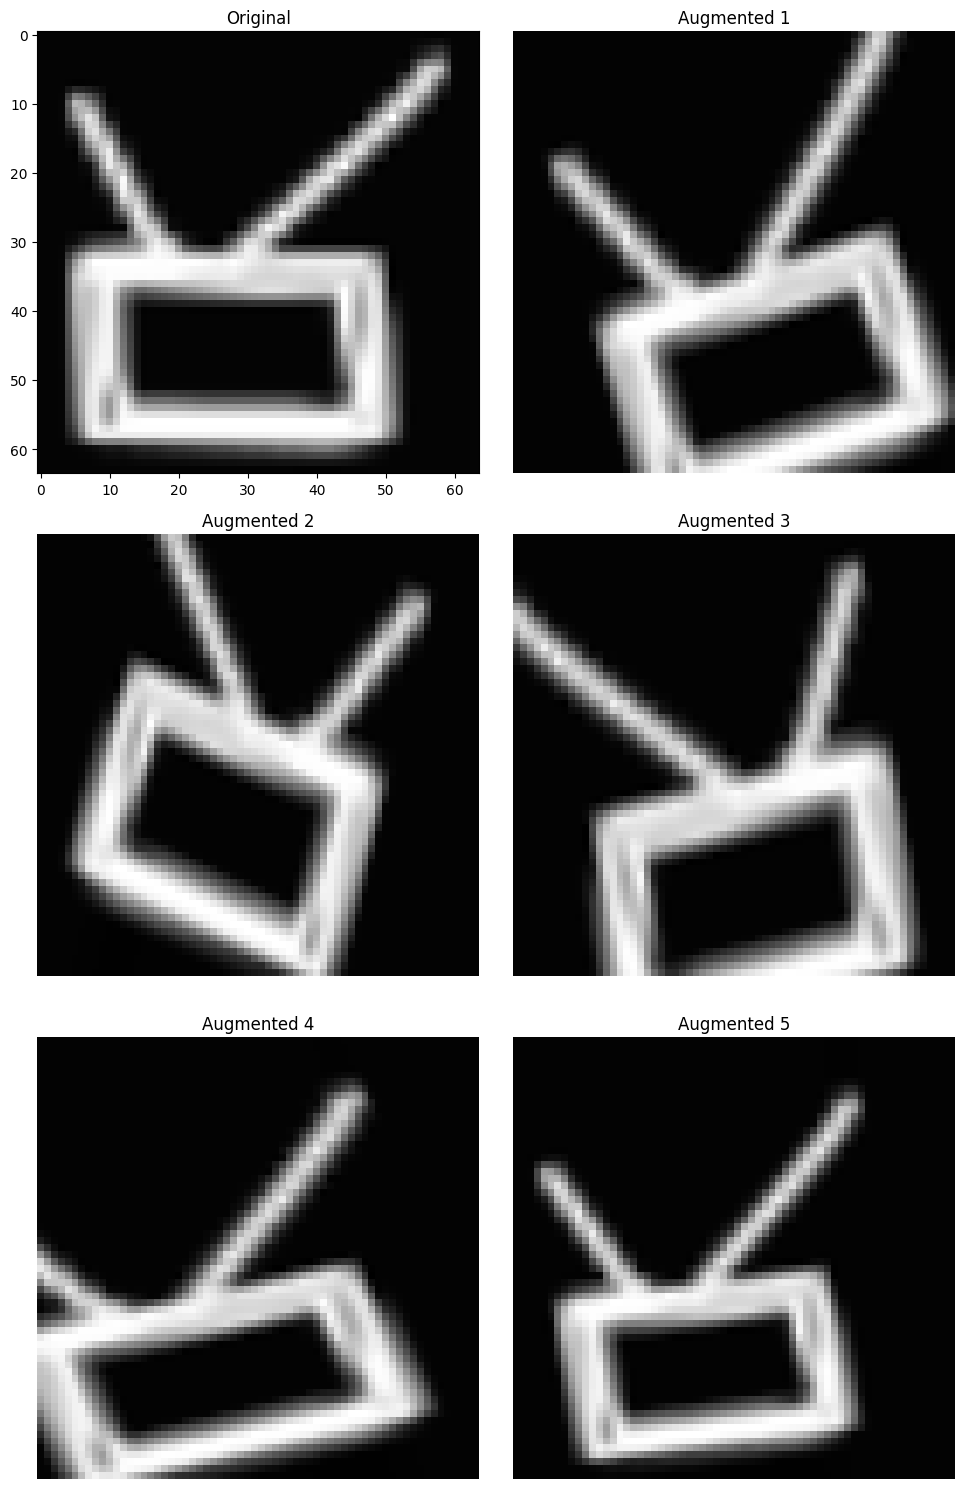

In [40]:
import matplotlib.pyplot as plt

# Choose an image index
image_index = 0

# Generate augmented images for the chosen image
augmented_images = []
for _ in range(5):  # Generate 5 augmented versions of the image
    augmented_image = datagen.random_transform(x_trainUSM1_reshaped[image_index])
    augmented_images.append(augmented_image)

# Visualize the original and augmented images
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes[0, 0].imshow(x_trainUSM1_reshaped[image_index].squeeze(), cmap='gray')
axes[0, 0].set_title('Original')
for i in range(5):
    row = (i + 1) // 2
    col = (i + 1) % 2
    axes[row, col].imshow(augmented_images[i].squeeze(), cmap='gray')
    axes[row, col].set_title(f'Augmented {i+1}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()


In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,      # Randomly rotate images in the range (degrees, 0 to 20)
    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # Randomly shift images vertically (fraction of total height)
    shear_range=0.05,        # Shear angle in counter-clockwise direction as radians
    zoom_range=0.05,         # Randomly zoom image
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=False,    # No vertical flipping
    fill_mode='nearest'     # Strategy used for filling in newly created pixels
)

# Fit the data augmentation generator to your training data
datagen.fit(x_trainUSM1_reshaped)

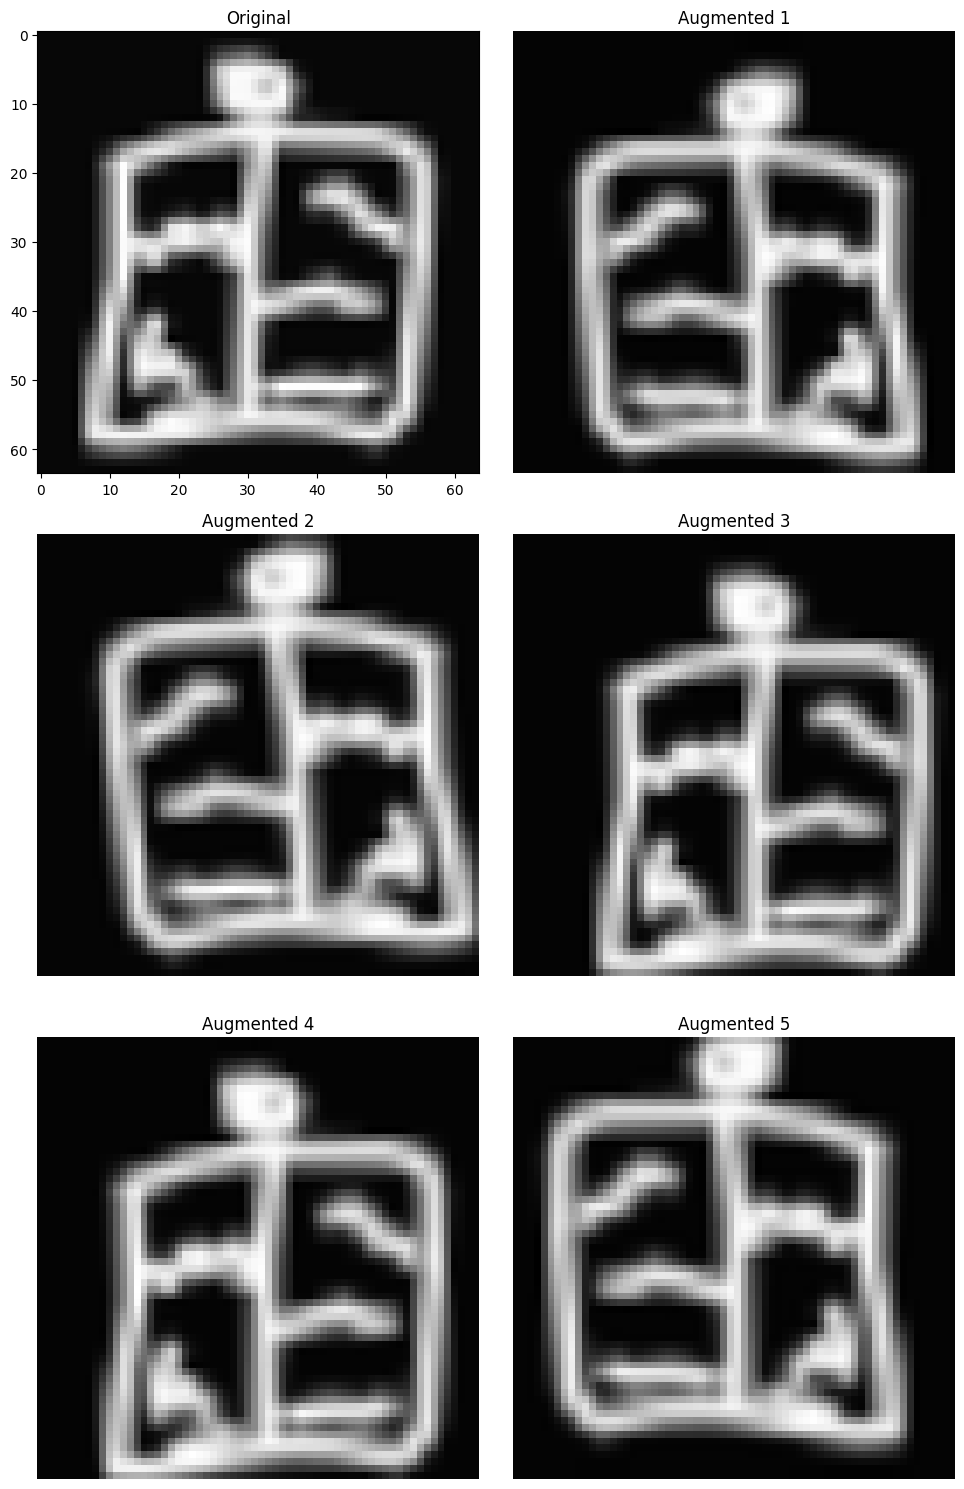

In [53]:
import matplotlib.pyplot as plt

# Choose an image index
image_index = 1

# Generate augmented images for the chosen image
augmented_images = []
for _ in range(5):  # Generate 5 augmented versions of the image
    augmented_image = datagen.random_transform(x_trainUSM1_reshaped[image_index])
    augmented_images.append(augmented_image)

# Visualize the original and augmented images
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes[0, 0].imshow(x_trainUSM1_reshaped[image_index].squeeze(), cmap='gray')
axes[0, 0].set_title('Original')
for i in range(5):
    row = (i + 1) // 2
    col = (i + 1) % 2
    axes[row, col].imshow(augmented_images[i].squeeze(), cmap='gray')
    axes[row, col].set_title(f'Augmented {i+1}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()


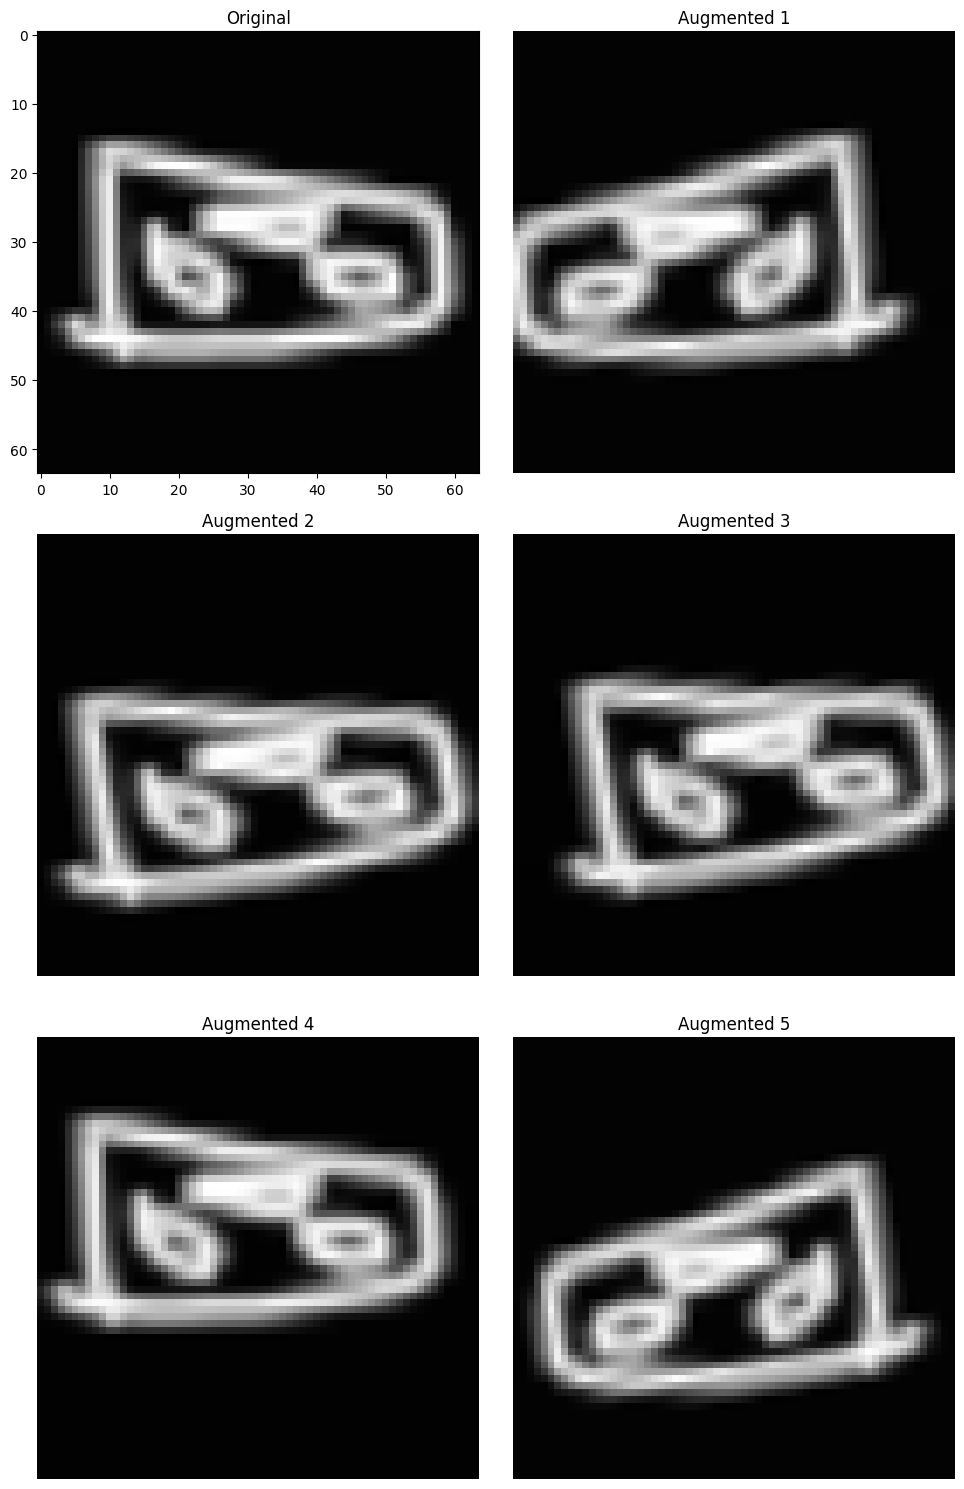

In [54]:
import matplotlib.pyplot as plt

# Choose an image index
image_index = 2

# Generate augmented images for the chosen image
augmented_images = []
for _ in range(5):  # Generate 5 augmented versions of the image
    augmented_image = datagen.random_transform(x_trainUSM1_reshaped[image_index])
    augmented_images.append(augmented_image)

# Visualize the original and augmented images
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes[0, 0].imshow(x_trainUSM1_reshaped[image_index].squeeze(), cmap='gray')
axes[0, 0].set_title('Original')
for i in range(5):
    row = (i + 1) // 2
    col = (i + 1) % 2
    axes[row, col].imshow(augmented_images[i].squeeze(), cmap='gray')
    axes[row, col].set_title(f'Augmented {i+1}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()


In [55]:
# Check the shape of Y_train
print("Shape of Y_train:", Y_train.shape)

# Check the first few labels in Y_train
print("First few labels in Y_train:", Y_train[:5])

Shape of Y_train: (85500, 12)
First few labels in Y_train: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [56]:
batch_size = 32
historyDataAug1 = modelDataAug1.fit(datagen.flow(x_trainUSM1_reshaped, Y_train, batch_size=32), 
                    steps_per_epoch=len(x_trainUSM1_reshaped) / batch_size, 
                    epochs=10, 
                    validation_data=(x_testUSM1_reshaped, Y_test))

Epoch 1/10
2671/2671 [==============================] - 53s 19ms/step - loss: 0.8061 - accuracy: 0.7466 - val_loss: 0.5732 - val_accuracy: 0.8153
Epoch 2/10
2671/2671 [==============================] - 52s 20ms/step - loss: 0.6331 - accuracy: 0.8026 - val_loss: 0.4966 - val_accuracy: 0.8420
Epoch 3/10
2671/2671 [==============================] - 52s 19ms/step - loss: 0.6079 - accuracy: 0.8112 - val_loss: 0.4949 - val_accuracy: 0.8476
Epoch 4/10
2671/2671 [==============================] - 51s 19ms/step - loss: 0.5976 - accuracy: 0.8154 - val_loss: 0.5018 - val_accuracy: 0.8462
Epoch 5/10
2671/2671 [==============================] - 52s 19ms/step - loss: 0.5983 - accuracy: 0.8149 - val_loss: 0.5044 - val_accuracy: 0.8527
Epoch 6/10
2671/2671 [==============================] - 51s 19ms/step - loss: 0.6186 - accuracy: 0.8106 - val_loss: 0.5044 - val_accuracy: 0.8462
Epoch 7/10
2671/2671 [==============================] - 51s 19ms/step - loss: 0.6252 - accuracy: 0.8118 - val_loss: 0.5215 -

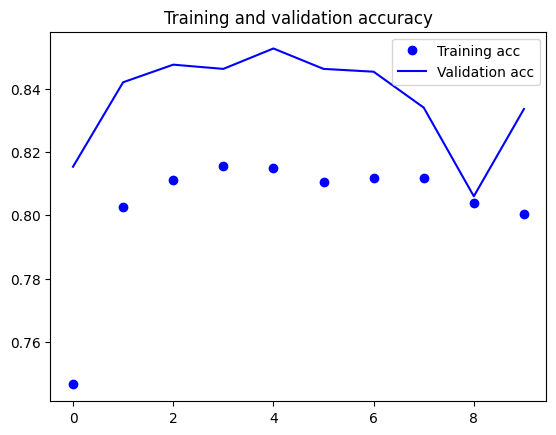

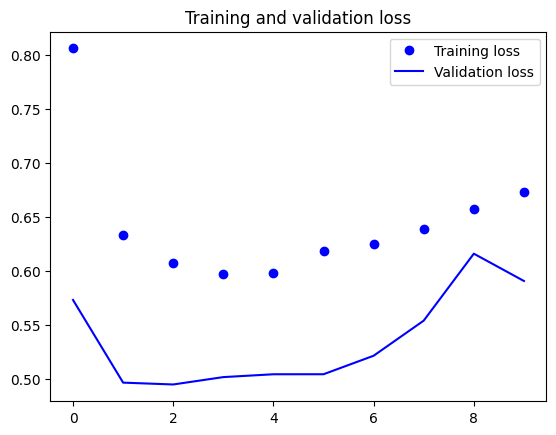

In [57]:
plotFromHistory(historyDataAug1)

The results show an improvement in validation accuracy from approximately 0.815 in the first epoch to around 0.834 in the last epoch after applying data augmentation. This suggests that data augmentation has indeed helped improve the model's performance.

Data augmentation is a common technique used to artificially increase the size of the training dataset by applying various transformations such as rotation, shifting, zooming, flipping, etc., to the original images. This helps expose the model to a wider variety of data during training, thereby enhancing its ability to generalize to new, unseen data.

By applying data augmentation with lower rotation, shear, and zoom ranges, you have effectively increased the diversity of the training data while ensuring that the transformations are not too extreme, thus improving the model's performance on the validation set. Overall, it seems that data augmentation has helped the model generalize better to unseen data, leading to improved validation accuracy.

However, compared to without using data augmentation, the model performance did not improve. Since our dataset already contains a wide variety of samples that adequately represent the target distribution, data augmentation may not provide much additional benefit. On the other hand, if our dataset is small or lacks diversity, data augmentation could still be beneficial, which was not the case.

### Tuning Model Architecture

In [26]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput1 = model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                 

In [27]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput2 = model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                 

In [28]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(256, (3,3), activation="relu"))
#model.add(Conv2D(256, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))


# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput3 = model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [41]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput4 = model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_26 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_28 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [42]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput5 = model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_31 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_33 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [43]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput6 = model

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_36 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_38 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [44]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput7 = model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_41 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_43 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [45]:
# Creating the ConvNet, adding a process each step of the way.
model = Sequential()

# The input shape is 28 x 28 because of the image size, and 1 is due to it being black and white image (1 channel instead of 3 channels for RGB).
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(64,64,1)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
# A resizing kind of error. Simplified image.
model.add(MaxPooling2D(pool_size = (2,2)))

# Dropout layers ensure that we are not overfitting the model.
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.5))

# The N_CATEGORIES is present because we want the number of nodes to be the same as the number of categories.
model.add(Dense(N_CATEGORIES, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()
modelInput8 = model

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 conv2d_46 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_48 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 13, 13, 64)        0         
 ng2D)                                                

In [29]:
historyInput1 = modelInput1.fit(
    np.array(x_trainUSM1),
    np.array(Y_train),
    batch_size=32,
    epochs=10,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 21s 8ms/step - loss: 0.7257 - accuracy: 0.7742 - val_loss: 0.7027 - val_accuracy: 0.8098
Epoch 2/10
2138/2138 [==============================] - 16s 8ms/step - loss: 1.3000 - accuracy: 0.8301 - val_loss: 1.6386 - val_accuracy: 0.7970
Epoch 3/10
2138/2138 [==============================] - 16s 8ms/step - loss: 1.7948 - accuracy: 0.8182 - val_loss: 2.9257 - val_accuracy: 0.8149
Epoch 4/10
2138/2138 [==============================] - 16s 8ms/step - loss: 1.0186 - accuracy: 0.8233 - val_loss: 1.3180 - val_accuracy: 0.8418
Epoch 5/10
2138/2138 [==============================] - 16s 8ms/step - loss: 0.5197 - accuracy: 0.8479 - val_loss: 0.9195 - val_accuracy: 0.8400
Epoch 6/10
2138/2138 [==============================] - 16s 8ms/step - loss: 2.3479 - accuracy: 0.8574 - val_loss: 4.3490 - val_accuracy: 0.8331
Epoch 7/10
2138/2138 [==============================] - 16s 8ms/step - loss: 0.5756 - accuracy: 0.8329 - val_loss: 0.5922 - val_ac

In [30]:
historyInput2 = modelInput2.fit(
    np.array(x_trainUSM1),
    np.array(Y_train),
    batch_size=32,
    epochs=10,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 21s 9ms/step - loss: 0.7013 - accuracy: 0.7862 - val_loss: 1.0412 - val_accuracy: 0.7901
Epoch 2/10
2138/2138 [==============================] - 17s 8ms/step - loss: 1.7356 - accuracy: 0.8193 - val_loss: 2.2786 - val_accuracy: 0.8405
Epoch 3/10
2138/2138 [==============================] - 17s 8ms/step - loss: 1.4441 - accuracy: 0.8323 - val_loss: 2.7677 - val_accuracy: 0.7869
Epoch 4/10
2138/2138 [==============================] - 17s 8ms/step - loss: 0.7297 - accuracy: 0.8286 - val_loss: 0.9856 - val_accuracy: 0.8608
Epoch 5/10
2138/2138 [==============================] - 17s 8ms/step - loss: 0.8568 - accuracy: 0.8619 - val_loss: 1.8087 - val_accuracy: 0.8626
Epoch 6/10
2138/2138 [==============================] - 17s 8ms/step - loss: 1.0365 - accuracy: 0.8634 - val_loss: 1.7810 - val_accuracy: 0.8418
Epoch 7/10
2138/2138 [==============================] - 17s 8ms/step - loss: 0.5775 - accuracy: 0.8646 - val_loss: 1.2291 - val_ac

In [31]:
historyInput3 = modelInput3.fit(
    np.array(x_trainUSM1),
    np.array(Y_train),
    batch_size=32,
    epochs=10,
    validation_split=0.2  # 20% of training data will be used for validation
)

Epoch 1/10
2138/2138 [==============================] - 22s 9ms/step - loss: 0.7970 - accuracy: 0.7527 - val_loss: 0.9029 - val_accuracy: 0.8109
Epoch 2/10
2138/2138 [==============================] - 18s 8ms/step - loss: 1.4045 - accuracy: 0.8261 - val_loss: 1.7035 - val_accuracy: 0.8431
Epoch 3/10
2138/2138 [==============================] - 18s 9ms/step - loss: 1.0060 - accuracy: 0.8357 - val_loss: 1.1921 - val_accuracy: 0.8509
Epoch 4/10
2138/2138 [==============================] - 18s 8ms/step - loss: 0.6038 - accuracy: 0.8478 - val_loss: 1.0242 - val_accuracy: 0.8506
Epoch 5/10
2138/2138 [==============================] - 18s 9ms/step - loss: 0.7623 - accuracy: 0.8641 - val_loss: 1.0414 - val_accuracy: 0.8539
Epoch 6/10
2138/2138 [==============================] - 18s 9ms/step - loss: 0.5761 - accuracy: 0.8589 - val_loss: 0.9318 - val_accuracy: 0.8500
Epoch 7/10
2138/2138 [==============================] - 18s 8ms/step - loss: 0.5243 - accuracy: 0.8642 - val_loss: 1.4329 - val_ac

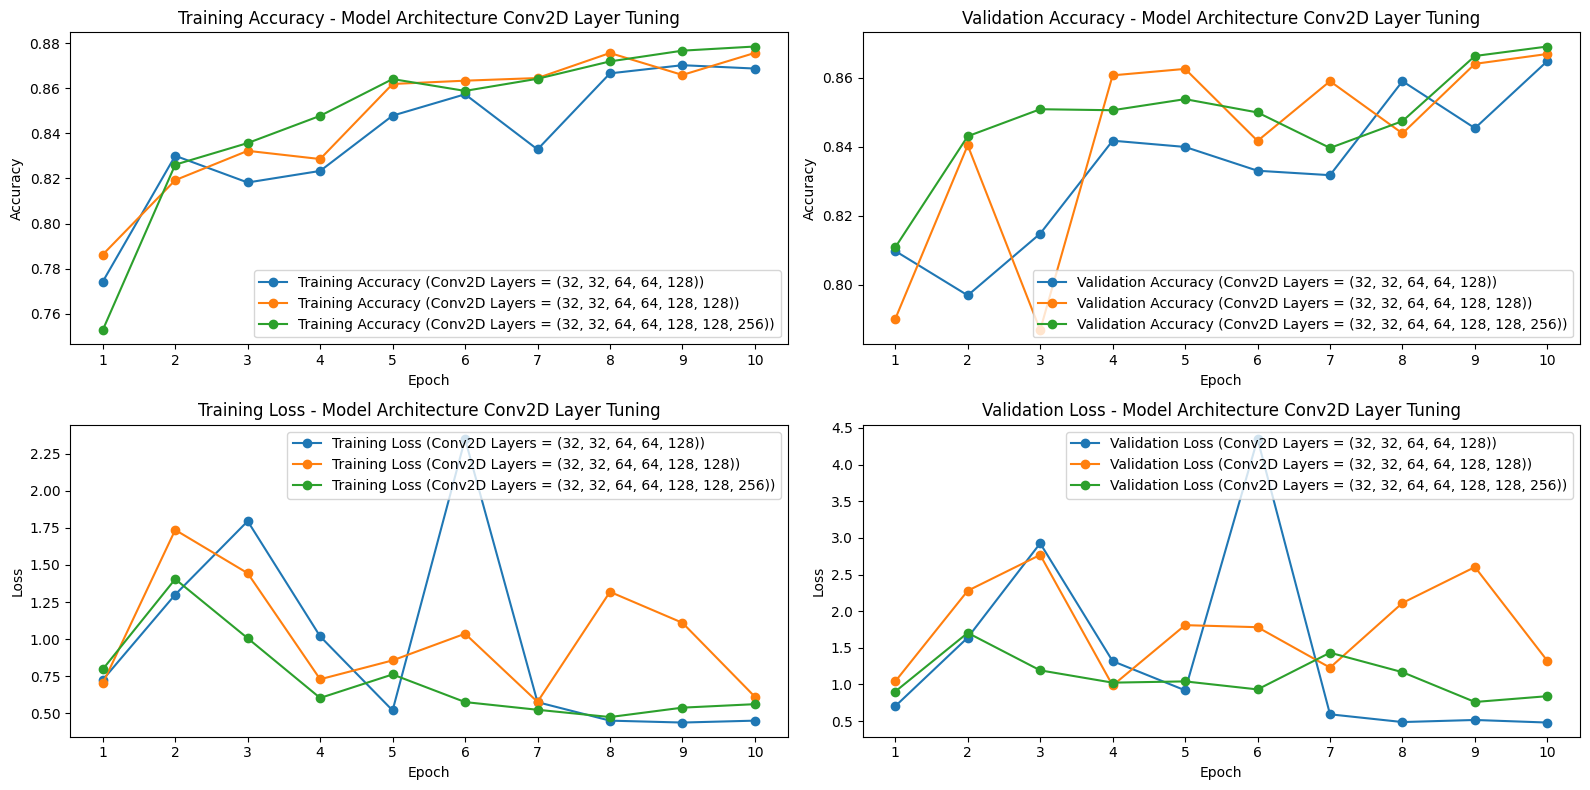

In [32]:
histories = [historyInput1, historyInput2, historyInput3]
title = 'Model Architecture Conv2D Layer Tuning'
hyperparam_name = 'Conv2D Layers'
hyperparam_values = [(32,32,64,64,128), (32,32,64,64,128,128), (32,32,64,64,128,128,256)]

plotFromHistories(histories, title, hyperparam_name, hyperparam_values)

In [47]:
# historyInput4 = modelInput4.fit(
#     np.array(x_trainUSM1),
#     np.array(Y_train),
#     batch_size=32,
#     epochs=10,
#     validation_split=0.2  # 20% of training data will be used for validation
# )

In [48]:
# historyInput5 = modelInput5.fit(
#     np.array(x_trainUSM1),
#     np.array(Y_train),
#     batch_size=32,
#     epochs=10,
#     validation_split=0.2  # 20% of training data will be used for validation
# )

In [2]:
# historyInput6 = modelInput6.fit(
#     np.array(x_trainUSM1),
#     np.array(Y_train),
#     batch_size=32,
#     epochs=10,
#     validation_split=0.2  # 20% of training data will be used for validation
# )

In [3]:
# historyInput7 = modelInput7.fit(
#     np.array(x_trainUSM1),
#     np.array(Y_train),
#     batch_size=32,
#     epochs=10,
#     validation_split=0.2  # 20% of training data will be used for validation
# )

In [4]:
# historyInput8 = modelInput8.fit(
#     np.array(x_trainUSM1),
#     np.array(Y_train),
#     batch_size=32,
#     epochs=10,
#     validation_split=0.2  # 20% of training data will be used for validation
# )

### Using High Pass Filtering (Not Used)

In [43]:
# def high_pass_filtering(image, kernel_size):
#     # Define the high-pass filter kernel with modified coefficients
#     kernel = np.array([[-1, -1, -1],
#                        [-1,  8, -1],
#                        [-1, -1, -1]])
#     # Apply the filter
#     sharpened = cv2.filter2D(image, -1, kernel)
#     return sharpened

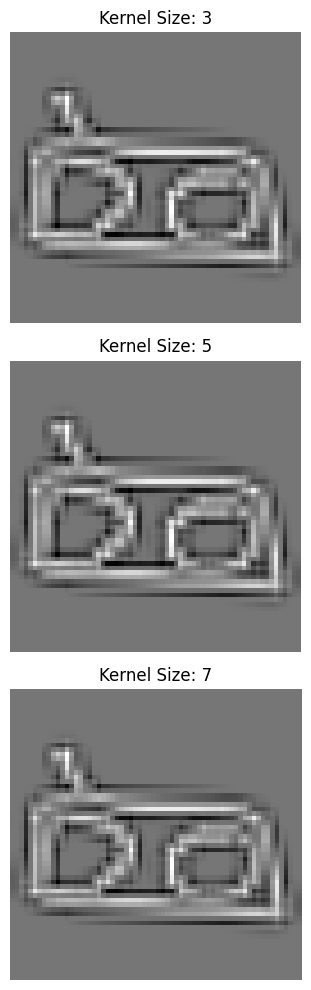

In [44]:
# # Define parameter combinations to tune
# kernel_sizes = [3, 5, 7]  # Size of the high-pass filter kernel

# # Visualize sharpened images for different parameter combinations
# fig, axes = plt.subplots(len(kernel_sizes), figsize=(6, 10))

# for i, kernel_size in enumerate(kernel_sizes):
#     # Apply high-pass filtering with current parameter combination
#     sharpened_image = high_pass_filtering(resized_x_train[0], kernel_size=kernel_size)
    
#     # Visualize the sharpened image
#     axes[i].imshow(sharpened_image.squeeze(), cmap='gray')
#     axes[i].axis('off')
#     axes[i].set_title(f"Kernel Size: {kernel_size}")

# plt.tight_layout()
# plt.show()